In [1]:
import ot
import torch

import torch.distributions as D
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils import data
from itertools import cycle
from tqdm.auto import trange

from hswfs.chswf import chswf
from hswfs.manifold.euclidean import Euclidean, Mahalanobis

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

In [3]:
n = 10000
d = 2

In [4]:
# Mixture

random_state = 42
torch.manual_seed(random_state)

d = 2
M = 5
l = 10

p = torch.ones(M)/M
mus = -l/2 + l * torch.rand((M,d), dtype=torch.float32, device=device)
sigmas = [torch.eye(d, device=device, dtype=torch.float32) for i in range(M)]

mix = D.Categorical(p.to(device))
comp = D.Independent(D.Normal(mus,torch.ones(M,2,device=device)),1)

gm = D.MixtureSameFamily(mix, comp)

X = gm.sample((n,))
ydata = torch.zeros(len(X))

train_dataset = data.TensorDataset(X, ydata)

rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=500, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

batch_data0 = next(dataiter)[0]

## SWF

In [5]:
manifold = Euclidean(d)
n = 500

x0 = torch.randn(n, d, device=device)

L = chswf(x0, 501, dataiter, manifold, tauk=0.1, n_projs=500)

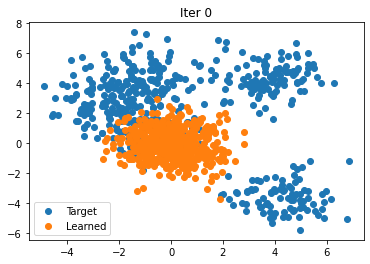

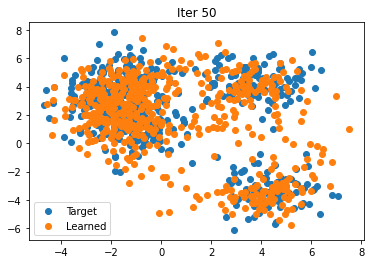

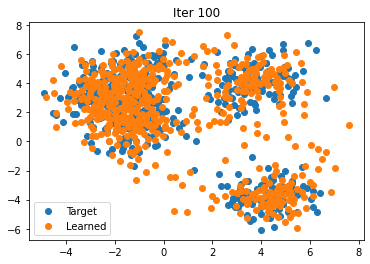

In [6]:
for k in range(0, 101, 50):
    target = next(dataiter)[0].detach()
    
    plt.scatter(target[:,0], target[:,1], label="Target")
    plt.scatter(L[k][:,0], L[k][:,1], label="Learned")
    plt.legend()
    plt.title("Iter "+str(k))
    plt.show()

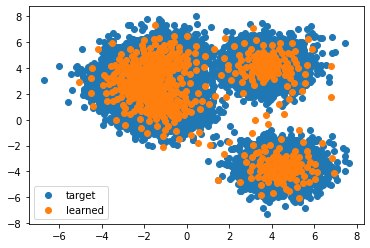

In [7]:
plt.scatter(X[:,0],X[:,1],label="target")
plt.scatter(L[-1][:,0],L[-1][:,1], label="learned")
plt.legend()
plt.show()

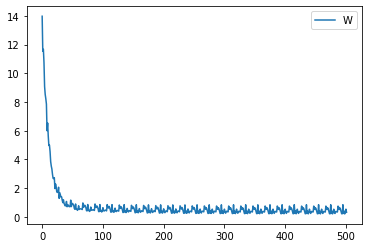

In [8]:
L_w = []

for x in L:
    target = next(dataiter)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = ot.dist(x, target, metric="sqeuclidean")
        
    w = ot.emd2(a, b, M)
    L_w.append(w.item())


plt.plot(L_w, label="W")
plt.legend()
plt.show()

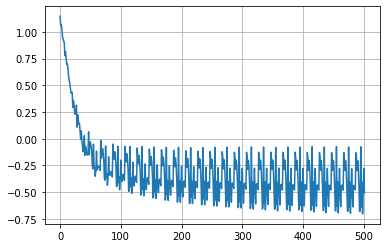

In [9]:
plt.plot(np.log10(np.array(L_w)))
plt.grid(True)
plt.show()

## MSWF

In [10]:
m0 = D.Wishart(torch.tensor([2], dtype=torch.float).to(device), 
               torch.eye(2, dtype=torch.float, device=device))

In [11]:
# A = torch.eye(d)
A = m0.sample((1,))[0,0]

manifold = Mahalanobis(d, A)
n = 500

x0 = torch.randn(n, d, device=device)

L = chswf(x0, 501, dataiter, manifold, tauk=0.1, n_projs=500)

/home/clement/anaconda3/lib/python3.7/site-packages/torch/distributions/wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


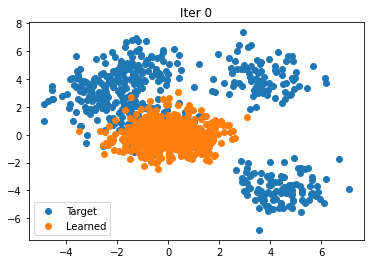

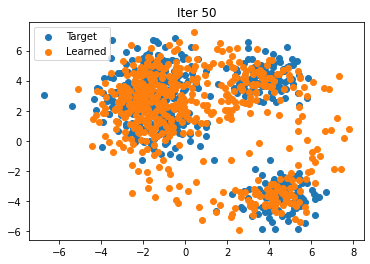

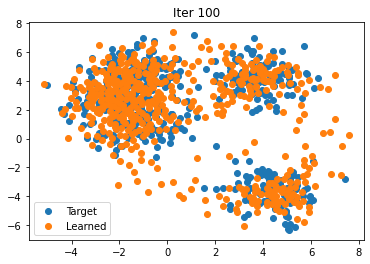

In [12]:
for k in range(0, 101, 50):
    target = next(dataiter)[0].detach()
    
    plt.scatter(target[:,0], target[:,1], label="Target")
    plt.scatter(L[k][:,0], L[k][:,1], label="Learned")
    plt.legend()
    plt.title("Iter "+str(k))
    plt.show()

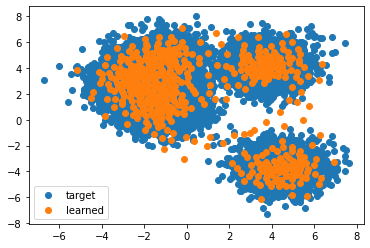

In [13]:
plt.scatter(X[:,0],X[:,1],label="target")
plt.scatter(L[-1][:,0],L[-1][:,1], label="learned")
plt.legend()
plt.show()

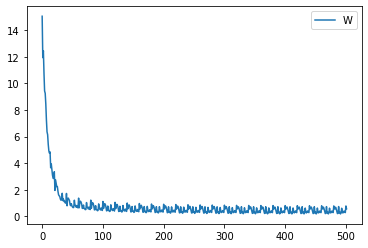

In [14]:
L_w = []

for x in L:
    target = next(dataiter)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = ot.dist(x, target, metric="sqeuclidean")
        
    w = ot.emd2(a, b, M)
    L_w.append(w.item())


plt.plot(L_w, label="W")
plt.legend()
plt.show()

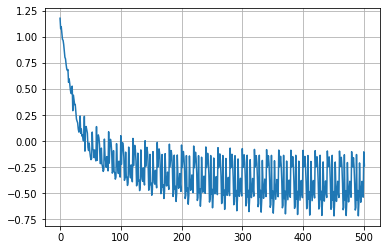

In [15]:
plt.plot(np.log10(np.array(L_w)))
plt.grid(True)
plt.show()

## Illustration Projections

In [16]:
# theta = F.normalize(torch.randn(1,2), p=2, dim=-1).numpy()

theta = np.array([[ 0.32391253, -0.946087  ]])

ts = np.linspace(-1,1,100)[:,None]
line = ts * theta
e1 = ts * np.array([[1,0]])
e2 = ts * np.array([[0,1]])

x0 = torch.tensor([[1,0]])
x1 = torch.tensor([[0,1]])


alpha = np.arccos(np.sum(theta*np.array([[1,0]])))
angles = np.linspace(0,alpha,100)

xs = np.cos(angles)
ys = np.sum(theta * np.array([[0,1]])) * np.sin(angles)


# source = torch.tensor([[0.5,0]]) + 0.25 * torch.randn((5,2))
# target = torch.tensor([[-0.5, 0.5]]) + 0.25 * torch.randn((5,2))

source = torch.tensor([[1, -1]]) + torch.randn((5,2))
target = torch.tensor([[-0.5, 0]]) + torch.randn((5,2))

source = source.numpy()
target = target.numpy()

proj_source = np.sum(theta * source, axis=-1)[:,None] * theta
proj_target = np.sum(theta * target, axis=-1)[:,None] * theta


def proj_euc(x, theta):
    return (x @ theta).T * theta

proj_source = proj_euc(source, theta.T).T
proj_target = proj_euc(target, theta.T).T

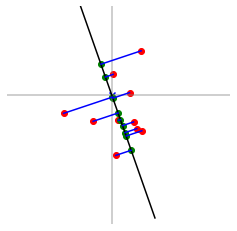

In [17]:
fig = plt.figure(figsize=(4,4))

ts = np.linspace(-6,6,100)[:,None]
line = ts * theta

# plt.plot(e1[:,0], e1[:,1], c="black")
# plt.plot(e2[:,0], e2[:,1], c="black")

ts = np.linspace(-10,10,100)[:,None]
e1 = ts * np.array([[1,0]])
e2 = ts * np.array([[0,1]])

plt.plot(e1[:,0], e1[:,1], c="gray", alpha=0.5)
plt.plot(e2[:,0], e2[:,1], c="gray", alpha=0.5)

plt.plot(line[:,0], line[:,1], c="black")

# plt.plot(0.2 * xs, 0.2 * ys, c="black")
# plt.arrow(0,0,theta[0,0],theta[0,1],head_width=0.05, head_length=0.1, color="black")

plt.scatter([0], [0], c="b", marker="x")

plt.scatter(source[:,0], source[:,1], c="r") #, label="Source")
plt.scatter(target[:,0], target[:,1], c='r') #, label="Target")

plt.scatter(proj_source[:,0], proj_source[:,1], c="g") #, label="Projected Source")
plt.scatter(proj_target[:,0], proj_target[:,1], c="g") #, label="Projected Target")

t = np.linspace(0,1,100)[:,None]

for k in range(len(proj_source)):
    inter = (1-t)*source[k] + t*proj_source[k]
    plt.plot(inter[:,0], inter[:,1], c="blue")  #, linewidth=0.5)
    
    inter = (1-t)*target[k] + t*proj_target[k]
    plt.plot(inter[:,0], inter[:,1], c="blue") #, linewidth=0.5)

# plt.legend(fontsize=13)

plt.xlim(theta[0,0]-5, theta[0,0]+5)
plt.ylim(theta[0,1]-5, theta[0,1]+5)
plt.axis("off")

# plt.savefig("./Projection_SW_v2.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [40]:
A = m0.sample((1,))[0,0]

manifold = Mahalanobis(d, A)
v = manifold.sample_geodesics(1)

theta = v.numpy()

In [41]:
def proj_mahalanobis(x, theta, A):
    return np.einsum("ni,ij,mj -> mn", x, A, theta).T * theta

proj_source = manifold.proj(torch.tensor(source).type(torch.float), v).T * v
proj_target = manifold.proj(torch.tensor(target).type(torch.float), v).T * v

proj_source = proj_source.numpy()
proj_target = proj_target.numpy()

print(proj_source.shape)

(5, 2)


(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)


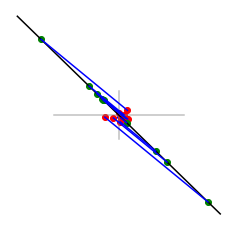

In [43]:
fig = plt.figure(figsize=(4,4))

ts = np.linspace(-6,6,100)[:,None]
line = ts * theta

# plt.plot(e1[:,0], e1[:,1], c="black")
# plt.plot(e2[:,0], e2[:,1], c="black")

ts = np.linspace(-10,10,100)[:,None]
e1 = ts * np.array([[1,0]])
e2 = ts * np.array([[0,1]])

plt.plot(e1[:,0], e1[:,1], c="gray", alpha=0.5)
plt.plot(e2[:,0], e2[:,1], c="gray", alpha=0.5)

plt.plot(line[:,0], line[:,1], c="black")

# plt.plot(0.2 * xs, 0.2 * ys, c="black")
# plt.arrow(0,0,theta[0,0],theta[0,1],head_width=0.05, head_length=0.1, color="black")

plt.scatter([0], [0], c="b", marker="x")

plt.scatter(source[:,0], source[:,1], c="r") #, label="Source")
plt.scatter(target[:,0], target[:,1], c='r') #, label="Target")

plt.scatter(proj_source[:,0], proj_source[:,1], c="g") #, label="Projected Source")
plt.scatter(proj_target[:,0], proj_target[:,1], c="g") #, label="Projected Target")

t = np.linspace(0,1,100)[:,None]

for k in range(len(proj_source)):
    print(source.shape, proj_source.shape)
    inter = (1-t)*source[k] + t*proj_source[k]
    plt.plot(inter[:,0], inter[:,1], c="blue")  #, linewidth=0.5)
    
    inter = (1-t)*target[k] + t*proj_target[k]
    plt.plot(inter[:,0], inter[:,1], c="blue") #, linewidth=0.5)

# plt.legend(fontsize=13)

# plt.xlim(theta[0,0]-5, theta[0,0]+5)
# plt.ylim(theta[0,1]-5, theta[0,1]+5)
plt.axis("off")

# plt.savefig("./Projection_SW_v2.pdf", format="pdf", bbox_inches="tight")

plt.show()